# 2. Unsupervised Dimensional Reduction (PCA/SVD, ICA, and NMF)

## Setting

In [1]:
import subprocess
repo_url = "https://github.com/chiba-ai-med/PyTorchDecomp.git"
install_command = f"pip install git+{repo_url}"
subprocess.check_call(install_command, shell=True)
subprocess.check_call('pip install scikit-learn', shell=True)

  Cloning https://github.com/chiba-ai-med/PyTorchDecomp.git to /private/var/folders/k0/tk8gl4bj2_v2mbjx80ydsznw0000gn/T/pip-req-build-ipvhykg6


  Running command git clone --filter=blob:none --quiet https://github.com/chiba-ai-med/PyTorchDecomp.git /private/var/folders/k0/tk8gl4bj2_v2mbjx80ydsznw0000gn/T/pip-req-build-ipvhykg6


  Resolved https://github.com/chiba-ai-med/PyTorchDecomp.git to commit c3bf715e40fa8ae48b903a79f2102304b8ecaa98
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


0

## Package Loading

In [2]:
import torch
import torch.nn as nn
import torchdecomp as td
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Pre-processing Function

In [3]:
transform = transforms.ToTensor()

## Data Download

/Users/tsuyusakikouki/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


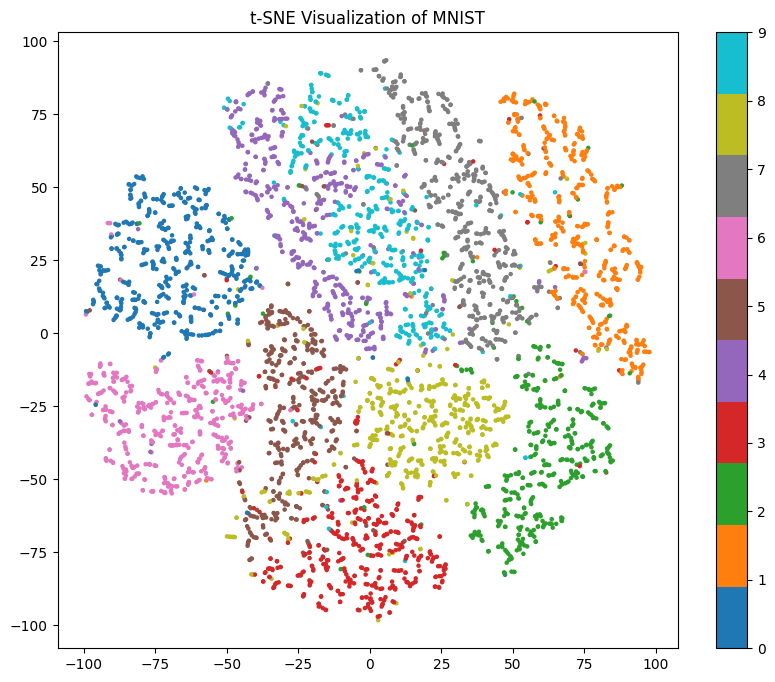

In [4]:
## Data Download
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Subsampling
torch.manual_seed(123456)
subset_indices = torch.randperm(len(mnist_dataset))[:5000]
mnist_subset = torch.utils.data.Subset(mnist_dataset, subset_indices)
all_data = torch.stack([sample[0] for sample in mnist_subset], dim=0)

# PyTorch Tensor to Numpy Array
data_np = all_data.numpy().reshape(all_data.size(0), -1)

# Numpy Array to PyTorch Tensor
data_torch = torch.tensor(data_np)

# t-SNE
torch.manual_seed(123456)
embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(data_np)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## PCA (rec-mode + Square Error)

### Normalization of data matrix

In [5]:
data_torch_norm = torch.nn.functional.normalize(data_torch, dim=0)

### Instantiation of RecLayer

In [6]:
torch.manual_seed(123456)
rec_layer = td.RecLayer(x=data_torch_norm, n_components=10)

### Setting Optimizer

In [7]:
optimizer = optim.SGD(rec_layer.parameters(), lr=2e-3)

### Weights for each objective function

In [8]:
weights = np.array([2, 1])
weights = weights / sum(weights)

### Iteration

In [9]:
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = rec_layer(data_torch_norm)
    # Loss
    ortho_loss_V = torch.norm(torch.eye(rec_layer.V.size(1)) - torch.mm(rec_layer.V.t(), rec_layer.V))
    loss = weights[0] * torch.sum((data_torch_norm - x_pred)**2) + weights[1] * ortho_loss_V
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

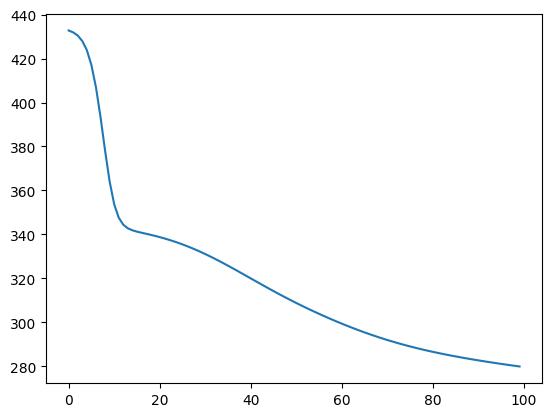

In [10]:
plt.plot(loss_array)

### Pattern Check

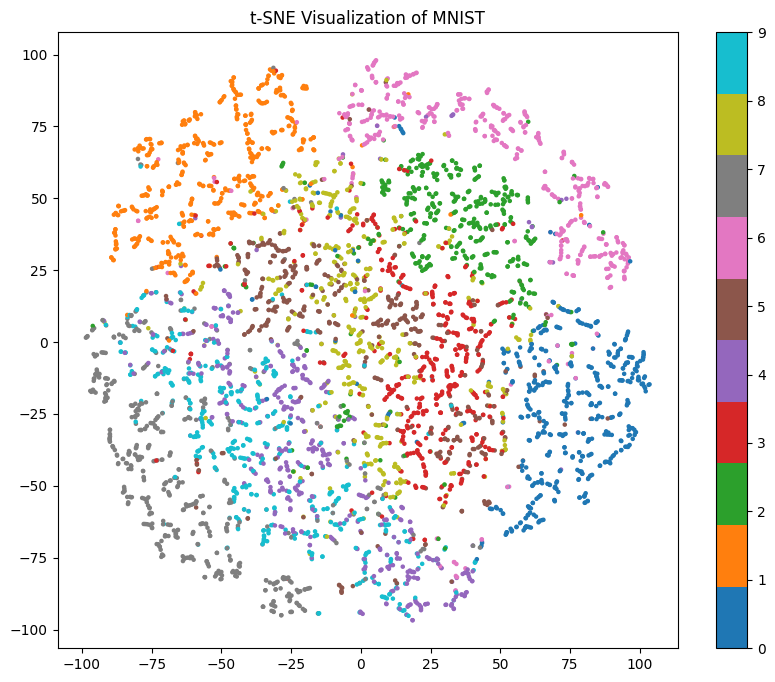

In [11]:
# t-SNE with PCA 
pca_score = data_torch.numpy() @ rec_layer.V.detach().numpy()
torch.manual_seed(123456)
pca_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(pca_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## PCA (factor-mode × Variance)

### Instantiation of FactorLayer

In [12]:
torch.manual_seed(123456)
factor_layer = td.FactorLayer(x=data_torch_norm, n_components=10)

### Setting Optimizer

In [13]:
optimizer = optim.SGD(factor_layer.parameters(), lr=2e-7)

### Weights for each objective function

In [14]:
weights = np.array([20, 1])
weights = weights / sum(weights)

### Iteration

In [15]:
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Forward
    x_pred = factor_layer(data_torch_norm)
    # Loss
    ortho_loss_V = torch.norm(torch.eye(factor_layer.V.size(1)) - torch.mm(factor_layer.V.t(), factor_layer.V))
    loss = - weights[0] * torch.var(x_pred) + weights[1] * ortho_loss_V
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

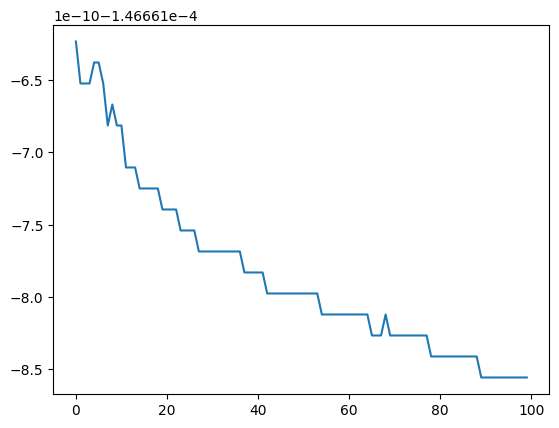

In [16]:
plt.plot(loss_array)

### Pattern Check

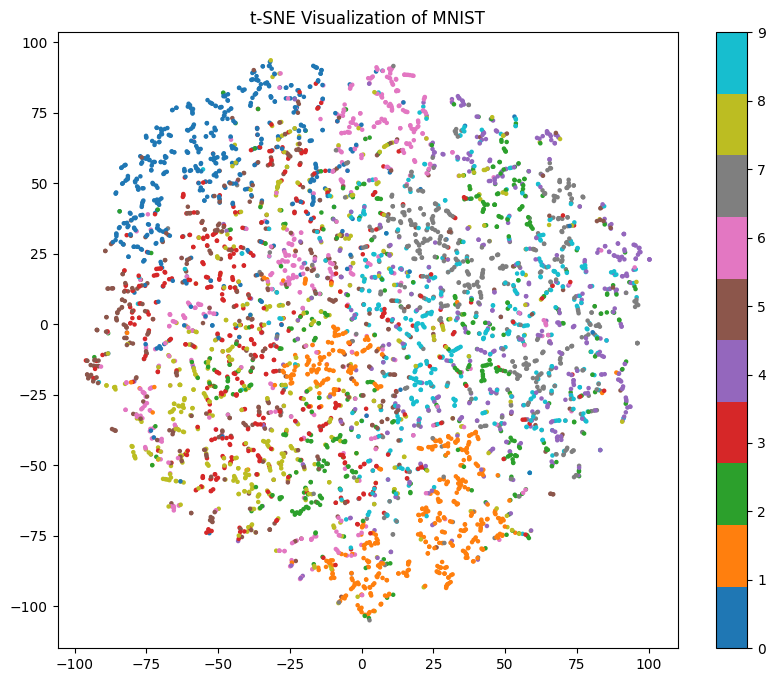

In [17]:
# t-SNE with PCA 
pca_var_score = data_torch.numpy() @ factor_layer.V.detach().numpy()
torch.manual_seed(123456)
pca_var_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(pca_var_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(pca_var_embedding[:, 0], pca_var_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## ICA (Kurtosis)

### Whitening data matrix

In [18]:
white_score_np = pca_score / np.linalg.norm(pca_score, axis=0)
white_score_torch = torch.tensor(white_score_np)

### Instantiation of RotationLayer

In [19]:
rotation_layer = td.RotationLayer(white_score_torch)

### Loss Function (Kurtosis)

In [20]:
loss_kurtosis = td.KurtosisICALayer()

### Setting Optimizer

In [21]:
optimizer = torch.optim.SGD(rotation_layer.parameters(), lr=0.05)

### Iteration

In [22]:
loss_array = []
epochs = 100
for epoch in range(epochs):
    # モデルの出力の取得
    outputs_kurtosis = rotation_layer(white_score_torch)    
    # 損失関数：分布の尖度の最大化
    loss = loss_kurtosis(outputs_kurtosis)
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # 勾配の初期化と逆伝播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

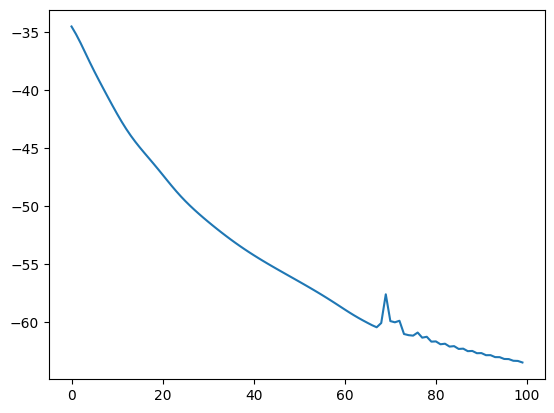

In [23]:
plt.plot(loss_array)
plt.show()

### Pattern Check

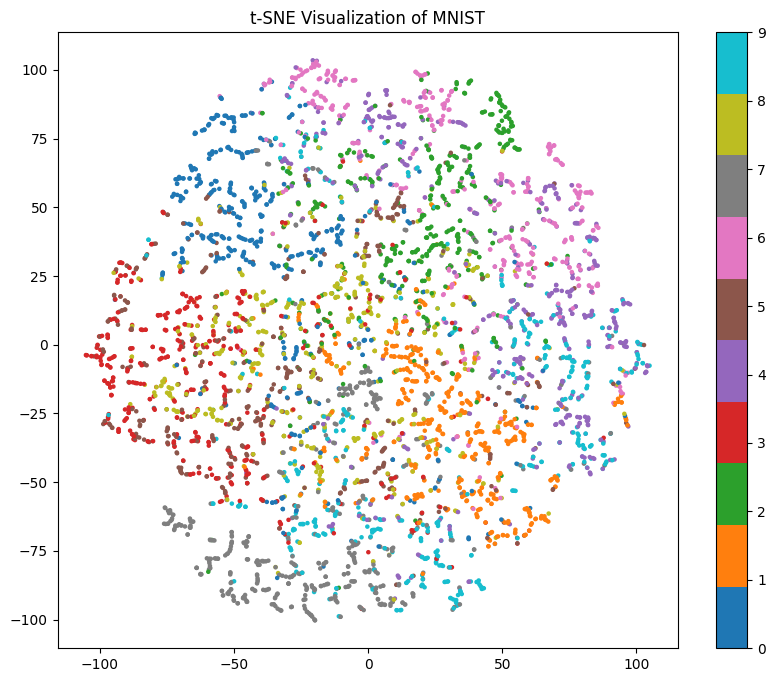

In [24]:
# t-SNE with ICA
ica_kurtosis_score = white_score_np @ rotation_layer.mixing_matrix.detach().numpy()
torch.manual_seed(123456)
ica_kurtosis_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(ica_kurtosis_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(ica_kurtosis_embedding[:, 0], ica_kurtosis_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## ICA (Negentropy)

### Instantiation of RotationLayer

In [25]:
rotation_layer = td.RotationLayer(white_score_torch)

### Loss Function (Negentropy)

In [26]:
loss_negentropy = td.NegentropyICALayer()

### Setting Optimizer

In [27]:
optimizer = torch.optim.SGD(rotation_layer.parameters(), lr=0.05)

### Iteration

In [28]:
loss_array = []
epochs = 100
for epoch in range(epochs):
    # モデルの出力の取得
    outputs_negentropy = rotation_layer(white_score_torch)    
    # 損失関数：分布の尖度の最大化
    loss = loss_negentropy(outputs_negentropy)
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # 勾配の初期化と逆伝播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

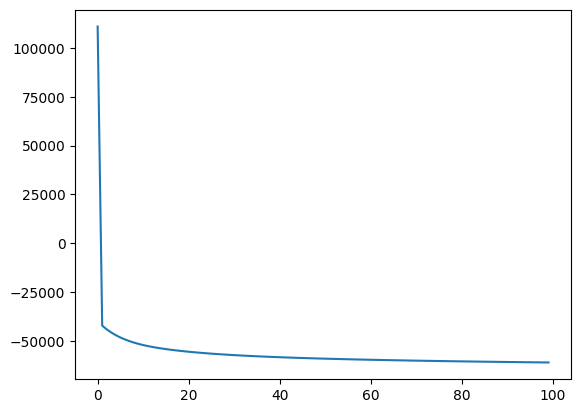

In [29]:
plt.plot(loss_array)
plt.show()

### Pattern Check

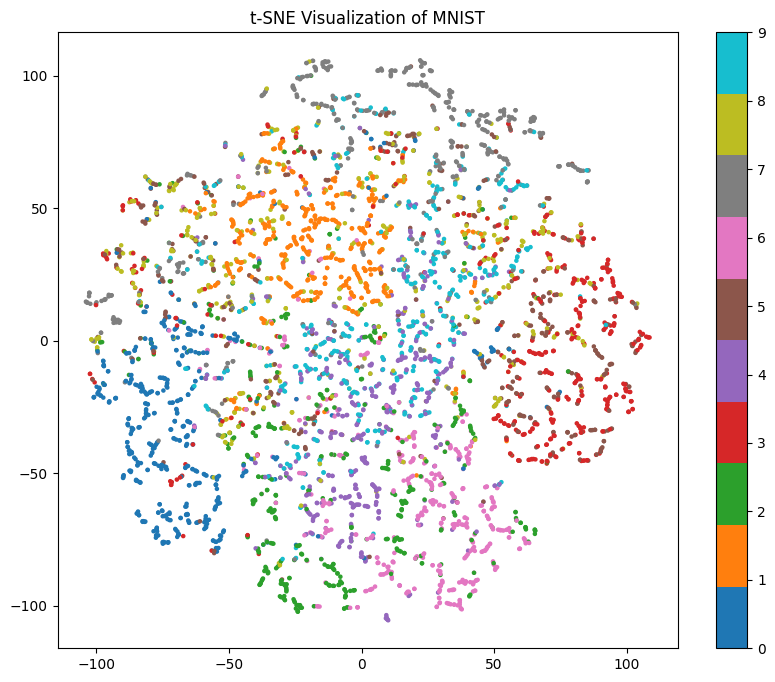

In [30]:
# t-SNE with ICA
ica_negentropy_score = white_score_np @ rotation_layer.mixing_matrix.detach().numpy()
torch.manual_seed(123456)
ica_negentropy_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(ica_negentropy_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(ica_negentropy_embedding[:, 0], ica_negentropy_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## ICA (DDICA)

### Instantiation of DDICALayer

In [31]:
torch.manual_seed(1233543)
ddica_layer = td.DDICALayer(white_score_torch[1:500,:], sigma=0.01, alpha=0.75)

### Setting Optimizer

In [32]:
optimizer = torch.optim.SGD(ddica_layer.parameters(), lr=5e-6)

### Iteration

In [33]:
loss_array = []
epochs = 30
for epoch in range(epochs):
    # モデルの出力の取得
    loss = ddica_layer(white_score_torch[1:500,:])
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # 勾配の初期化と逆伝播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### Convergence Check

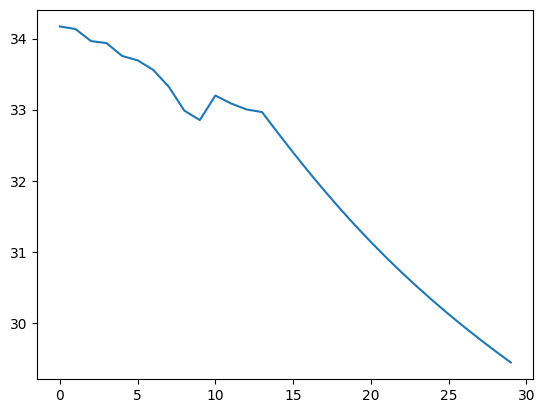

In [34]:
plt.plot(loss_array)
plt.show()

### Pattern Check

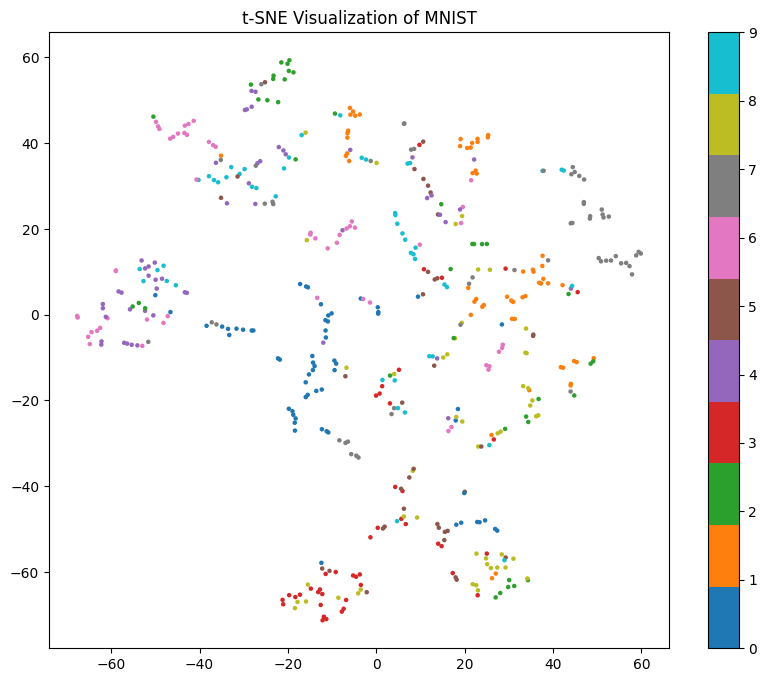

In [35]:
# t-SNE with DDICA
ddica_score = white_score_np[1:500,:] @ ddica_layer.mixing_matrix.detach().numpy()
torch.manual_seed(123456)
ddica_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(ddica_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(ddica_embedding[:, 0], ddica_embedding[:, 1], c=mnist_dataset.targets[subset_indices[1:500]], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()

## NMF (Beta-divergence)

### Instantiation of NMFLayer

In [36]:
nmf_layer = td.NMFLayer(data_torch, 10)

### Iteration

In [42]:
loss_array = []
epochs = 100
for epoch in range(epochs):
    # Initialize Gradient
    nmf_layer.zero_grad()
    # Forward
    loss, WH, pos, neg, pos_w, neg_w, pos_h, neg_h = nmf_layer(data_torch)
    # Loss
    loss_array.append(loss.to('cpu').detach().numpy().copy())
    # Multiplicative Update (MU) rule
    with torch.no_grad():
        # Gradients
        grad_pos = torch.autograd.grad(pos, WH, grad_outputs=torch.ones_like(pos))[0]
        grad_neg = torch.autograd.grad(neg, WH, grad_outputs=torch.ones_like(neg))[0]
        grad_pos_w = torch.autograd.grad(pos_w, nmf_layer.W, grad_outputs=torch.ones_like(pos_w))[0]
        grad_neg_w = torch.autograd.grad(neg_w, nmf_layer.W, grad_outputs=torch.ones_like(neg_w))[0]
        grad_pos_h = torch.autograd.grad(pos_h, nmf_layer.H, grad_outputs=torch.ones_like(pos_h))[0]
        grad_neg_h = torch.autograd.grad(neg_h, nmf_layer.H, grad_outputs=torch.ones_like(neg_h))[0]        
        # Update
        nmf_layer.W.data *= ((torch.mm(grad_neg, nmf_layer.H.data.T) + grad_neg_w) / (torch.mm(grad_pos, nmf_layer.H.data.T) + grad_pos_w))**td.rho(beta)
        nmf_layer.H.data *= ((torch.mm(nmf_layer.W.data.T, grad_neg) + grad_neg_h) / (torch.mm(nmf_layer.W.data.T, grad_pos) + grad_pos_h))**td.rho(beta)
        # Normalization
        nmf_layer.W.data = torch.nn.functional.normalize(nmf_layer.W.data, dim=0)
        nmf_layer.H.data = torch.nn.functional.normalize(nmf_layer.H.data, dim=1)

AttributeError: module 'torchdecomp' has no attribute 'rho'

### Convergence Check

In [ ]:
plt.plot(loss_array)
plt.show()

### Pattern Check

In [ ]:
# t-SNE with NMF
nmf_score = nmf_layer.W.data.detach().numpy()
torch.manual_seed(123456)
nmf_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(nmf_score)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(nmf_embedding[:, 0], nmf_embedding[:, 1], c=mnist_dataset.targets[subset_indices], cmap='tab10', s=5)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST')
plt.show()